In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [2]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Toy data generation
*  [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [26]:
n_samples = int(1e3)
n_features = 20
n_informative = 2
n_classes = 2

x, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=2,
    n_classes=n_classes,
    random_state=random_state)

y = tfk.utils.to_categorical(y).astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2 / 0.8)

In [28]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

# Data Visualization

In [29]:
# df = {'x{}'.format(i): x_train[:, i] for i in [1, 3, 5, 7, 9]}
df = {'x{}'.format(i): x_train[:, i] for i in range(0, n_features, 4)}
variables = list(df.keys())
print(variables)
df['y'] = y_train[:, 1]
df = pd.DataFrame(df)

['x0', 'x4', 'x8', 'x12', 'x16']


In [30]:
df.head()

,x0,x4,x8,x12,x16,y
0,0.519404,0.607385,0.655009,0.797625,0.620403,1
1,0.293022,0.346059,0.175987,0.455891,0.397458,0
2,0.524672,0.419495,0.678851,0.420291,0.386065,1
3,0.734108,0.555672,0.395539,0.266978,0.300880,1
4,0.515839,0.624200,0.496020,0.187853,0.394411,0


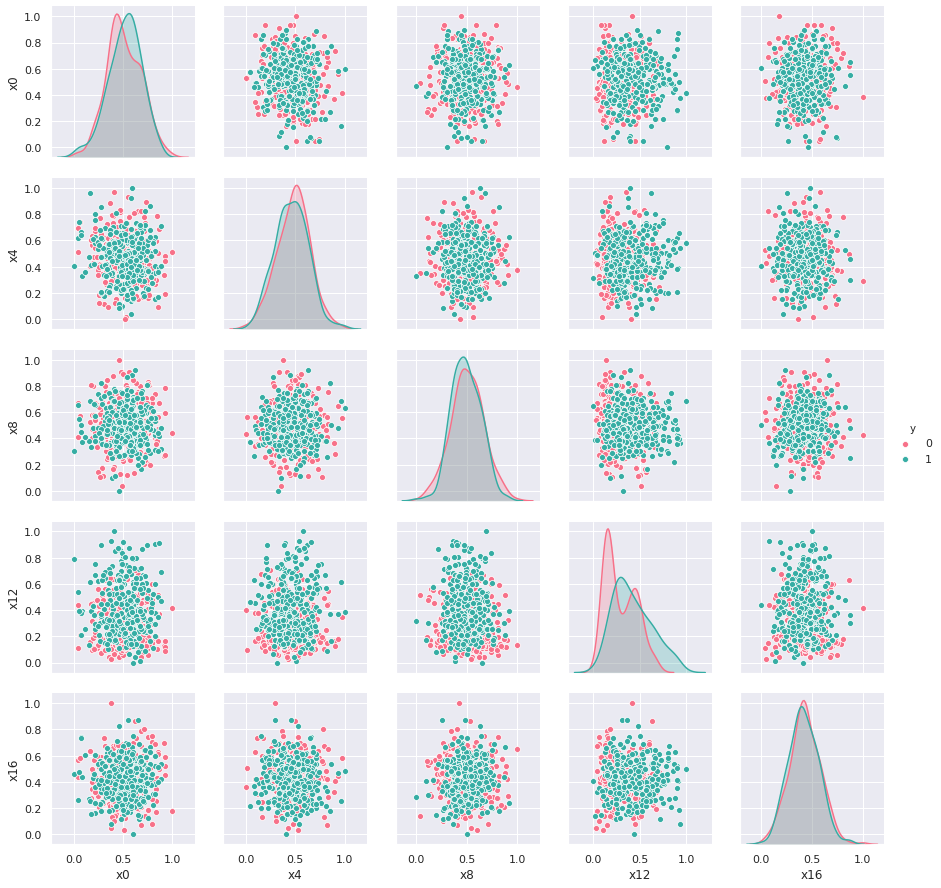

In [32]:
sns.pairplot(df, hue='y', vars=variables, palette="husl")

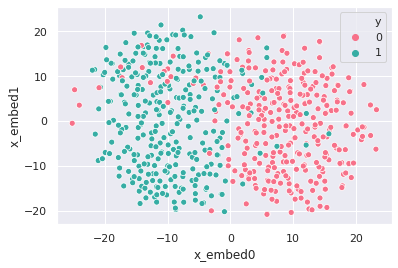

In [33]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_train)
df['x_embed0'] = x_embed[:, 0]
df['x_embed1'] = x_embed[:, 1]
sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")

# Create deterministic model

In [34]:
model = tf.keras.Sequential([
    tfkl.Dense(128),
    tfkl.ReLU(),
    tfkl.Dense(n_classes),
    tfkl.Softmax(),
])

In [35]:
model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [36]:
history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=100,
    shuffle=True,
    validation_data=(x_valid, y_valid),
    verbose=0)

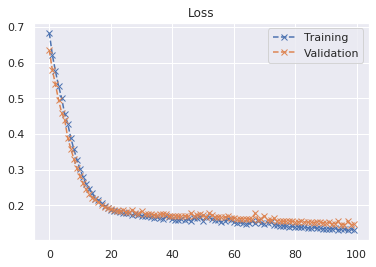

In [37]:
kwargs = {'ls': '--', 'marker': 'x'}
plt.plot(history.history['loss'], label='Training', **kwargs)
plt.plot(history.history['val_loss'], label="Validation", **kwargs)
plt.title("Loss")
plt.legend()

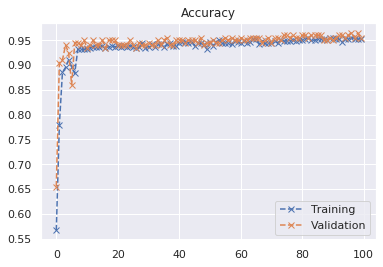

In [38]:
kwargs = {'ls': '--', 'marker': 'x'}
plt.plot(history.history['acc'], label='Training', **kwargs)
plt.plot(history.history['val_acc'], label="Validation", **kwargs)
plt.title("Accuracy")
plt.legend()

In [39]:
loss, acc = model.evaluate(x_test, y_test)

200/200 [==============================] - 0s 215us/sample - loss: 0.1851 - acc: 0.9450


# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [40]:
kl_weight = 1 / len(x_train)
print(kl_weight)

0.0016666666666666668


In [41]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [42]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    # c = 0.01
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [43]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [51]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(n_classes) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(n_classes),
])

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_4 (DenseVa (None, 128)               8064      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_variational_5 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 2), (None, 2))    0         
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.5),
              loss=negative_log_likelihood,
              metrics=['accuracy'])

In [54]:
history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=100,
    shuffle=True,
    validation_data=(x_valid, y_valid),
    verbose=False)

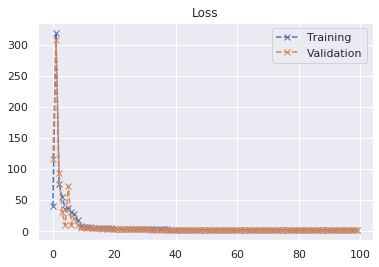

In [55]:
kwargs = {'ls': '--', 'marker': 'x'}
plt.plot(history.history['loss'], label='Training', **kwargs)
plt.plot(history.history['val_loss'], label="Validation", **kwargs)
plt.title("Loss")
plt.legend()

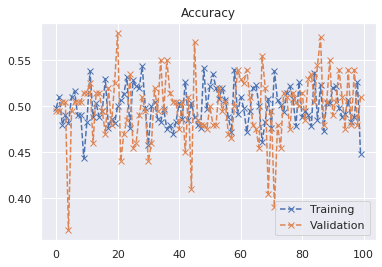

In [56]:
kwargs = {'ls': '--', 'marker': 'x'}
plt.plot(history.history['acc'], label='Training', **kwargs)
plt.plot(history.history['val_acc'], label="Validation", **kwargs)
plt.title("Accuracy")
plt.legend()